In [1]:
import logging
import pandas as pd
from tqdm import tqdm
from prophet import Prophet
from sklearn.metrics import (
    mean_squared_error,
    root_mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
from pathlib import Path
# from vangja.components import LinearTrend, FourierSeasonality, Constant
from vangja.data_utils import (
    download_data,
    process_data,
    generate_train_test_df_around_point,
)

logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled = True

/home/jovan/miniconda3/envs/pymc_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


# Fetch data

In [2]:
dfs = download_data(Path("./data"))
indexes = process_data(dfs[0])
smp = [index for index in indexes if index["series"].iloc[0] == "^GSPC"]
gspc_tickers = process_data(dfs[1])

# Generate models

In [3]:
model_components = [
    [LinearTrend(changepoint_range=1)],
    [
        FourierSeasonality(period=365.25, series_order=10, allow_tune=allow_tune)
        for allow_tune in [True]
    ],
    [
        FourierSeasonality(period=365.25 / 4, series_order=7, allow_tune=allow_tune)
        for allow_tune in [True]
    ],
    [
        FourierSeasonality(period=365.25 / 12, series_order=5, allow_tune=allow_tune)
        for allow_tune in [True, False]
    ],
    [
        FourierSeasonality(period=7, series_order=3, allow_tune=allow_tune)
        for allow_tune in [True, False]
    ],
]

In [4]:
q = [(0, [mc]) for mc in model_components[0]]
models = []

while len(q):
    level, model = q.pop(0)
    if level + 1 == len(model_components):
        models.append(model)
        continue

    mcs = model_components[level + 1]
    for mc in mcs:
        if mc.allow_tune:
            q.append((level + 1, model + [Constant(lower=-1, upper=1) * mc]))
            
        q.append((level + 1, model + [mc]))
        q.append((level + 1, model))

In [5]:
def sum_models(models):
    s = None
    for model in models:
        if s is None:
            s = model
        else:
            s += model

    return s

In [6]:
models = (
    [
        LinearTrend() * (FourierSeasonality(365.25, 10) + FourierSeasonality(7, 3)),
        LinearTrend() * FourierSeasonality(365.25, 10),
        LinearTrend() * FourierSeasonality(7, 3),
        LinearTrend() + FourierSeasonality(365.25, 10) + FourierSeasonality(7, 3),
        LinearTrend() + FourierSeasonality(365.25, 10),
        LinearTrend() + FourierSeasonality(7, 3),
    ]
    + [
        model[0] * sum_models(model[1:]) if len(model) > 1 else model[0]
        for model in models
    ]
    + [sum_models(model) if len(model) > 1 else model[0] for model in models]
)

In [7]:
str_models = {""}
final_models = []
for model in models:
    str_model = str(model)
    if ",n=7," not in str_model and ",n=5," not in str_model:
        continue
    
    if str_model in str_models:
        continue

    str_models.add(str_model)
    final_models.append(model)

len(final_models)

264

In [8]:
str_models

{'',
 'LT(n=25,r=1,at=False,complete) * (C(l=-1,u=1,at=False,complete) * FS(p=30.4375,n=5,at=True,complete) + C(l=-1,u=1,at=False,complete) * FS(p=7,n=3,at=True,complete))',
 'LT(n=25,r=1,at=False,complete) * (C(l=-1,u=1,at=False,complete) * FS(p=30.4375,n=5,at=True,complete) + FS(p=7,n=3,at=False,complete))',
 'LT(n=25,r=1,at=False,complete) * (C(l=-1,u=1,at=False,complete) * FS(p=30.4375,n=5,at=True,complete) + FS(p=7,n=3,at=True,complete))',
 'LT(n=25,r=1,at=False,complete) * (C(l=-1,u=1,at=False,complete) * FS(p=365.25,n=10,at=True,complete) + C(l=-1,u=1,at=False,complete) * FS(p=30.4375,n=5,at=True,complete) + C(l=-1,u=1,at=False,complete) * FS(p=7,n=3,at=True,complete))',
 'LT(n=25,r=1,at=False,complete) * (C(l=-1,u=1,at=False,complete) * FS(p=365.25,n=10,at=True,complete) + C(l=-1,u=1,at=False,complete) * FS(p=30.4375,n=5,at=True,complete) + FS(p=7,n=3,at=False,complete))',
 'LT(n=25,r=1,at=False,complete) * (C(l=-1,u=1,at=False,complete) * FS(p=365.25,n=10,at=True,complete) + C

# Run on validation set

In [ ]:
def set_tune_method(model, tune_method, beta_sd):
    if hasattr(model, "left"):
        set_tune_method(model.left, tune_method, beta_sd)
        set_tune_method(model.right, tune_method, beta_sd)

    if hasattr(model, "beta_sd") and model.allow_tune:
        model.tune_method = tune_method
        model.beta_sd = beta_sd


def is_tunable(model):
    left = False
    if hasattr(model, "left"):
        left = left or is_tunable(model.left)

    right = False
    if hasattr(model, "right"):
        right = right or is_tunable(model.right)

    allow_tune = False
    if hasattr(model, "allow_tune"):
        allow_tune = model.allow_tune

    return left or right or allow_tune

: 

In [ ]:
thread_models = final_models[:100]
point = "2014-01-01"

val_tickers = []
for gspc_ticker in tqdm(gspc_tickers):
    check = generate_train_test_df_around_point(
        window=91,
        horizon=365,
        dfs=[gspc_ticker],
        for_prophet=False,
        point=point,
    )

    if check is not None:
        val_tickers.append(check)


for context_size in range(40, 50, 10):
    train_df_smp, test_df_smp, scales_smp = generate_train_test_df_around_point(
        window=365 * context_size, horizon=365, dfs=smp, for_prophet=False, point=point
    )
    for model_idx, model in enumerate(thread_models):
        print(f"context: {context_size} years, {model}")
        set_tune_method(model, "linear", 10)
        if hasattr(model, "left"):
            model.left.changepoint_range = 1
        else:
            model.changepoint_range = 1
        model.fit(train_df_smp, progressbar=False)
        yhat = model.predict(365)
        print(
            f"context mape: {model.metrics(test_df_smp, yhat, pool_cols='series')['mape'].iloc[0]}"
        )

        tune_methods = ["linear"]
        if not is_tunable(model):
            tune_methods = ["linear"]

        for tune_method in tune_methods:
            set_tune_method(model, tune_method, 0.001)
            if hasattr(model, "left"):
                model.left.changepoint_range = 0.8
            else:
                model.changepoint_range = 0.8
            model_name = (
                str(model)
                .replace(",", "_")
                .replace("*", "MUL")
                .replace("+", "ADD")
                .replace(".", "_")
                .replace("=", "_")
            )
            csv_path = (
                Path("./")
                / "out"
                / "all_season"
                / f"vangja_{tune_method}_{context_size}_{model_idx}.csv"
            )
            if csv_path.is_file():
                continue

            model_metrics = []
            for val_ticker in tqdm(val_tickers):
                train_df_tickers, test_df_tickers, scales_tickers = val_ticker
                model.tune(train_df_tickers, progressbar=False)
                yhat = model.predict(365)
                model_metrics.append(
                    model.metrics(test_df_tickers, yhat, pool_cols="series")
                )

            final_metrics = pd.concat(model_metrics)
            final_metrics.to_csv(csv_path)
            print(f"val mape {tune_method}: {final_metrics['mape'].mean()}")

100%|██████████| 503/503 [00:02<00:00, 202.77it/s]


context: 40 years, LT(n=25,r=1,at=False,complete) * (C(l=-1,u=1,at=False,complete) * FS(p=365.25,n=10,at=True,complete) + C(l=-1,u=1,at=False,complete) * FS(p=91.3125,n=7,at=True,complete) + C(l=-1,u=1,at=False,complete) * FS(p=30.4375,n=5,at=True,complete) + C(l=-1,u=1,at=False,complete) * FS(p=7,n=3,at=True,complete))
context mape: 0.014142572906055577


 15%|█▌        | 66/437 [25:12<34:40:15, 336.43s/it]

context: 40 years, LT(n=25,r=0.8,at=False,complete) * (C(l=-1,u=1,at=False,complete) * FS(p=365.25,n=10,at=True,complete) + C(l=-1,u=1,at=False,complete) * FS(p=91.3125,n=7,at=True,complete) + FS(p=30.4375,n=5,at=False,complete) + C(l=-1,u=1,at=False,complete) * FS(p=7,n=3,at=True,complete))
context mape: 0.014219646591894028
100%|██████████| 437/437 [40:46<00:00,  5.60s/it] 
val mape simple: 0.27169445997248154

# Run Prophet on validation set

In [3]:
def get_prophet_metrics(y_trues, y_preds, horizon):
    result = None
    for y_true, y_pred in zip(y_trues, y_preds):
        group_name = y_true["series"].iloc[0]
        single_metrics = {"mse": {}, "rmse": {}, "mae": {}, "mape": {}}
        single_metrics["mse"][group_name] = mean_squared_error(
            y_true["y"], y_pred["yhat"][-horizon:]
        )
        single_metrics["rmse"][group_name] = root_mean_squared_error(
            y_true["y"], y_pred["yhat"][-horizon:]
        )
        single_metrics["mae"][group_name] = mean_absolute_error(
            y_true["y"], y_pred["yhat"][-horizon:]
        )
        single_metrics["mape"][group_name] = mean_absolute_percentage_error(
            y_true["y"], y_pred["yhat"][-horizon:]
        )
        if result is None:
            result = pd.DataFrame(single_metrics)
        else:
            result = pd.concat((result, pd.DataFrame(single_metrics)))

    return result

In [ ]:
train_df_ticker, test_df_tickers, scales_tickers = generate_train_test_df_around_point(
    window=91, horizon=365, dfs=gspc_tickers, for_prophet=True, point="2015-01-01"
)


for fo in [3, 4, 5, 6, 7]:
    forecasts = []
    for df, df_test in zip(train_df_ticker, test_df_tickers):
        train_df = df.copy()
        model = Prophet(
            seasonality_mode="multiplicative", n_changepoints=0
        ).add_seasonality("qfs", period=365.25 / 4, fourier_order=fo)

        model.fit(train_df)
        future = model.make_future_dataframe(periods=365, include_history=True)

        forecasts.append(model.predict(future))

    metrics = get_prophet_metrics(test_df_tickers, forecasts, 365)
    metrics.to_csv(csv_path)
    print(f"{fo} mape: {metrics['mape'].mean()}")

In [9]:
for point in pd.date_range("2015-01-01", "2017-01-01"):
    point = f"{point.year}-{'' if point.month > 9 else '0'}{point.month}-{'' if point.day > 9 else '0'}{point.day}"

    train_df_ticker, test_df_tickers, scales_tickers = (
        generate_train_test_df_around_point(
            window=91, horizon=365, dfs=gspc_tickers, for_prophet=True, point=point
        )
    )

    prophet_forecasts = []
    model_name = f"prophet_{point}_multiplicative_lt0_w"
    csv_path = Path("./") / "out" / "prophet" / "test2" / f"{model_name}.csv"
    if csv_path.is_file():
        prophet_metrics = pd.read_csv(csv_path, index_col=0)
        print(f"{model_name} mape: {prophet_metrics['mape'].mean()}")
        continue

    for df, df_test in zip(train_df_ticker, test_df_tickers):
        train_df = df.copy()
        prophet = Prophet(seasonality_mode="multiplicative", n_changepoints=0)

        prophet.fit(train_df)
        future = prophet.make_future_dataframe(periods=365, include_history=True)

        prophet_forecasts.append(prophet.predict(future))

    prophet_metrics = get_prophet_metrics(test_df_tickers, prophet_forecasts, 365)
    prophet_metrics.to_csv(csv_path)
    print(f"{model_name} mape: {prophet_metrics['mape'].mean()}")

prophet_2015-01-01_multiplicative_lt0_w mape: 0.3002842010692304
prophet_2015-01-02_multiplicative_lt0_w mape: 0.2996746882466293
prophet_2015-01-03_multiplicative_lt0_w mape: 0.2990015223634076
prophet_2015-01-04_multiplicative_lt0_w mape: 0.29804571155288956
prophet_2015-01-05_multiplicative_lt0_w mape: 0.2968213489993706
prophet_2015-01-06_multiplicative_lt0_w mape: 0.29532525133532533
prophet_2015-01-07_multiplicative_lt0_w mape: 0.2911225051872781
prophet_2015-01-08_multiplicative_lt0_w mape: 0.28739061531096105
prophet_2015-01-09_multiplicative_lt0_w mape: 0.2848978958771096
prophet_2015-01-10_multiplicative_lt0_w mape: 0.2803691177861993
prophet_2015-01-11_multiplicative_lt0_w mape: 0.27549272085782667
prophet_2015-01-12_multiplicative_lt0_w mape: 0.2703685712497729
prophet_2015-01-13_multiplicative_lt0_w mape: 0.2650134157914521
prophet_2015-01-14_multiplicative_lt0_w mape: 0.25984173160197105
prophet_2015-01-15_multiplicative_lt0_w mape: 0.2527322983530123
prophet_2015-01-16_m

In [21]:
point = "2014-01-01"

train_df_smp, test_df_smp, scales_smp = generate_train_test_df_around_point(
    window=365 * 40, horizon=365, dfs=smp, for_prophet=True, point=point
)
train_df_ticker, test_df_tickers, scales_tickers = generate_train_test_df_around_point(
    window=91, horizon=365, dfs=gspc_tickers, for_prophet=True, point=point
)

In [22]:
test_df_smp

[       typical_price         ds series         y
 31414    1841.782486 2014-01-01  ^GSPC  0.997875
 31415    1837.859985 2014-01-02  ^GSPC  0.995750
 31416    1832.987488 2014-01-03  ^GSPC  0.993110
 31417    1831.989166 2014-01-04  ^GSPC  0.992569
 31418    1830.990845 2014-01-05  ^GSPC  0.992028
 ...              ...        ...    ...       ...
 31774    2088.136678 2014-12-27  ^GSPC  1.131349
 31775    2088.755839 2014-12-28  ^GSPC  1.131685
 31776    2089.375000 2014-12-29  ^GSPC  1.132020
 31777    2084.215027 2014-12-30  ^GSPC  1.129224
 31778    2071.132507 2014-12-31  ^GSPC  1.122136
 
 [365 rows x 4 columns]]

In [23]:
for so_4y in range(3, 13):
    for so_10y in range(3, 13):
        context_prophet = (
            Prophet(seasonality_mode="multiplicative", changepoint_range=1)
            .add_seasonality("4y", 4 * 365.25, so_4y, mode="multiplicative")
            .add_seasonality("10y", 10 * 365.25, so_10y, mode="multiplicative")
        )
        context_prophet.fit(train_df_smp[0])
        context_future = context_prophet.make_future_dataframe(
            periods=365, include_history=True
        )
        context_yhat = context_prophet.predict(context_future)
        context_metrics = get_prophet_metrics(test_df_smp, [context_yhat], 365)
        print(f"4y: {so_4y}, 10y: {so_10y}, mape: {context_metrics['mape'].iloc[0]}")

4y: 3, 10y: 3, mape: 0.03695329461618262
4y: 3, 10y: 4, mape: 0.028930361576724253
4y: 3, 10y: 5, mape: 0.02907458044832793
4y: 3, 10y: 6, mape: 0.03041647854507045
4y: 3, 10y: 7, mape: 0.050022302521887795
4y: 3, 10y: 8, mape: 0.042523970434495954
4y: 3, 10y: 9, mape: 0.042471916835063864
4y: 3, 10y: 10, mape: 0.042692287250365134
4y: 3, 10y: 11, mape: 0.05934175621415602
4y: 3, 10y: 12, mape: 0.05708579044628995
4y: 4, 10y: 3, mape: 0.03441797924684357
4y: 4, 10y: 4, mape: 0.029205334294240548
4y: 4, 10y: 5, mape: 0.02903557891504591
4y: 4, 10y: 6, mape: 0.03027683633168361
4y: 4, 10y: 7, mape: 0.04947818627409024
4y: 4, 10y: 8, mape: 0.044057180856194804
4y: 4, 10y: 9, mape: 0.045726060209907
4y: 4, 10y: 10, mape: 0.04263341241607331
4y: 4, 10y: 11, mape: 0.06080637374004281
4y: 4, 10y: 12, mape: 0.05262347894807534
4y: 5, 10y: 3, mape: 0.04096528873082988
4y: 5, 10y: 4, mape: 0.037144299022528526
4y: 5, 10y: 5, mape: 0.037412900485999816
4y: 5, 10y: 6, mape: 0.035379635530118955
4y

In [25]:
output = """
4y: 3, 10y: 3, mape: 0.03695329461618262
4y: 3, 10y: 4, mape: 0.028930361576724253
4y: 3, 10y: 5, mape: 0.02907458044832793
4y: 3, 10y: 6, mape: 0.03041647854507045
4y: 3, 10y: 7, mape: 0.050022302521887795
4y: 3, 10y: 8, mape: 0.042523970434495954
4y: 3, 10y: 9, mape: 0.042471916835063864
4y: 3, 10y: 10, mape: 0.042692287250365134
4y: 3, 10y: 11, mape: 0.05934175621415602
4y: 3, 10y: 12, mape: 0.05708579044628995
4y: 4, 10y: 3, mape: 0.03441797924684357
4y: 4, 10y: 4, mape: 0.029205334294240548
4y: 4, 10y: 5, mape: 0.02903557891504591
4y: 4, 10y: 6, mape: 0.03027683633168361
4y: 4, 10y: 7, mape: 0.04947818627409024
4y: 4, 10y: 8, mape: 0.044057180856194804
4y: 4, 10y: 9, mape: 0.045726060209907
4y: 4, 10y: 10, mape: 0.04263341241607331
4y: 4, 10y: 11, mape: 0.06080637374004281
4y: 4, 10y: 12, mape: 0.05262347894807534
4y: 5, 10y: 3, mape: 0.04096528873082988
4y: 5, 10y: 4, mape: 0.037144299022528526
4y: 5, 10y: 5, mape: 0.037412900485999816
4y: 5, 10y: 6, mape: 0.035379635530118955
4y: 5, 10y: 7, mape: 0.050491552803909795
4y: 5, 10y: 8, mape: 0.043779292504394635
4y: 5, 10y: 9, mape: 0.04054724204420103
4y: 5, 10y: 10, mape: 0.042556140320878705
4y: 5, 10y: 11, mape: 0.054067212523826465
4y: 5, 10y: 12, mape: 0.05190044017048776
4y: 6, 10y: 3, mape: 0.058634439628592494
4y: 6, 10y: 4, mape: 0.046739307936371786
4y: 6, 10y: 5, mape: 0.04670344026125739
4y: 6, 10y: 6, mape: 0.04370175515257454
4y: 6, 10y: 7, mape: 0.052098504052327195
4y: 6, 10y: 8, mape: 0.04558466377845315
4y: 6, 10y: 9, mape: 0.048452880214677835
4y: 6, 10y: 10, mape: 0.04705478498461486
4y: 6, 10y: 11, mape: 0.05890647096968979
4y: 6, 10y: 12, mape: 0.060152354407160935
4y: 7, 10y: 3, mape: 0.059725309984114995
4y: 7, 10y: 4, mape: 0.05384282075307639
4y: 7, 10y: 5, mape: 0.053779384147744386
4y: 7, 10y: 6, mape: 0.050353761301754625
4y: 7, 10y: 7, mape: 0.05566425801077445
4y: 7, 10y: 8, mape: 0.05145743387064841
4y: 7, 10y: 9, mape: 0.051530060927073275
4y: 7, 10y: 10, mape: 0.05010423936738381
4y: 7, 10y: 11, mape: 0.058945468160332366
4y: 7, 10y: 12, mape: 0.0639309301234166
4y: 8, 10y: 3, mape: 0.056108525594461445
4y: 8, 10y: 4, mape: 0.051680886179837834
4y: 8, 10y: 5, mape: 0.05233960482521944
4y: 8, 10y: 6, mape: 0.048342214581532324
4y: 8, 10y: 7, mape: 0.05378261304008158
4y: 8, 10y: 8, mape: 0.05011902541950906
4y: 8, 10y: 9, mape: 0.050143966255751016
4y: 8, 10y: 10, mape: 0.051990769131841995
4y: 8, 10y: 11, mape: 0.06026444614850121
4y: 8, 10y: 12, mape: 0.06455881261828329
4y: 9, 10y: 3, mape: 0.058075725411211886
4y: 9, 10y: 4, mape: 0.053380111825362724
4y: 9, 10y: 5, mape: 0.05297201134588698
4y: 9, 10y: 6, mape: 0.048961629780146516
4y: 9, 10y: 7, mape: 0.05353994274226005
4y: 9, 10y: 8, mape: 0.0501296531396101
4y: 9, 10y: 9, mape: 0.0521516720521546
4y: 9, 10y: 10, mape: 0.05102944317852506
4y: 9, 10y: 11, mape: 0.060553593201779554
4y: 9, 10y: 12, mape: 0.06416025705692699
4y: 10, 10y: 3, mape: 0.05278077112404472
4y: 10, 10y: 4, mape: 0.048632262599216124
4y: 10, 10y: 5, mape: 0.04967092001550511
4y: 10, 10y: 6, mape: 0.04698870056900801
4y: 10, 10y: 7, mape: 0.05307624041502278
4y: 10, 10y: 8, mape: 0.04733283738296814
4y: 10, 10y: 9, mape: 0.04894247885770057
4y: 10, 10y: 10, mape: 0.048516501986794254
4y: 10, 10y: 11, mape: 0.05520733364711297
4y: 10, 10y: 12, mape: 0.06182996390678124
4y: 11, 10y: 3, mape: 0.053915994725184734
4y: 11, 10y: 4, mape: 0.047047102089117325
4y: 11, 10y: 5, mape: 0.04776179242483167
4y: 11, 10y: 6, mape: 0.04617192932092979
4y: 11, 10y: 7, mape: 0.054057576911037915
4y: 11, 10y: 8, mape: 0.04712355425301405
4y: 11, 10y: 9, mape: 0.048819698329582786
4y: 11, 10y: 10, mape: 0.04896017445248858
4y: 11, 10y: 11, mape: 0.05833061158371179
4y: 11, 10y: 12, mape: 0.06114555777588617
4y: 12, 10y: 3, mape: 0.05627459556358786
4y: 12, 10y: 4, mape: 0.04778530128933135
4y: 12, 10y: 5, mape: 0.0482582716971675
4y: 12, 10y: 6, mape: 0.04825754666144801
4y: 12, 10y: 7, mape: 0.05417118137432954
4y: 12, 10y: 8, mape: 0.04775209784832357
4y: 12, 10y: 9, mape: 0.048960133580953254
4y: 12, 10y: 10, mape: 0.04880965391180835
4y: 12, 10y: 11, mape: 0.058048872378422975
4y: 12, 10y: 12, mape: 0.06270833457220829
"""
parts = []
lines = output.split("\n")
for line in lines:
    if len(line) == 0:
        continue

    parts.append(line.split(", mape: "))

sorted(parts, key=lambda x: float(x[1]))

[['4y: 3, 10y: 4', '0.028930361576724253'],
 ['4y: 4, 10y: 5', '0.02903557891504591'],
 ['4y: 3, 10y: 5', '0.02907458044832793'],
 ['4y: 4, 10y: 4', '0.029205334294240548'],
 ['4y: 4, 10y: 6', '0.03027683633168361'],
 ['4y: 3, 10y: 6', '0.03041647854507045'],
 ['4y: 4, 10y: 3', '0.03441797924684357'],
 ['4y: 5, 10y: 6', '0.035379635530118955'],
 ['4y: 3, 10y: 3', '0.03695329461618262'],
 ['4y: 5, 10y: 4', '0.037144299022528526'],
 ['4y: 5, 10y: 5', '0.037412900485999816'],
 ['4y: 5, 10y: 9', '0.04054724204420103'],
 ['4y: 5, 10y: 3', '0.04096528873082988'],
 ['4y: 3, 10y: 9', '0.042471916835063864'],
 ['4y: 3, 10y: 8', '0.042523970434495954'],
 ['4y: 5, 10y: 10', '0.042556140320878705'],
 ['4y: 4, 10y: 10', '0.04263341241607331'],
 ['4y: 3, 10y: 10', '0.042692287250365134'],
 ['4y: 6, 10y: 6', '0.04370175515257454'],
 ['4y: 5, 10y: 8', '0.043779292504394635'],
 ['4y: 4, 10y: 8', '0.044057180856194804'],
 ['4y: 6, 10y: 8', '0.04558466377845315'],
 ['4y: 4, 10y: 9', '0.045726060209907'],

In [29]:
old_metrics = pd.read_csv("./out/vangja/test16/2015-01-01.csv", index_col=0)
new_metrics = pd.read_csv("./out/vangja/test17/2015-01-01.csv", index_col=0)
(old_metrics - new_metrics).mean()

mse    -0.000065
rmse   -0.000226
mae    -0.000181
mape   -0.000167
dtype: float64

In [14]:
context_prophet = (
    Prophet(seasonality_mode="multiplicative")
    # .add_seasonality("4y", 4 * 365.25, so_4y, mode="multiplicative")
    # .add_seasonality("10y", 10 * 365.25, so_10y, mode="multiplicative")
)
context_prophet.fit(train_df_smp[0])
context_future = context_prophet.make_future_dataframe(
    periods=365, include_history=True
)
context_yhat = context_prophet.predict(context_future)
context_metrics = get_prophet_metrics(test_df_smp, [context_yhat], 365)
context_metrics

,mse,rmse,mae,mape
^GSPC,0.081087,0.284758,0.281898,0.268346


In [11]:
context_metrics["mape"].iloc[0]

0.08107283794205777

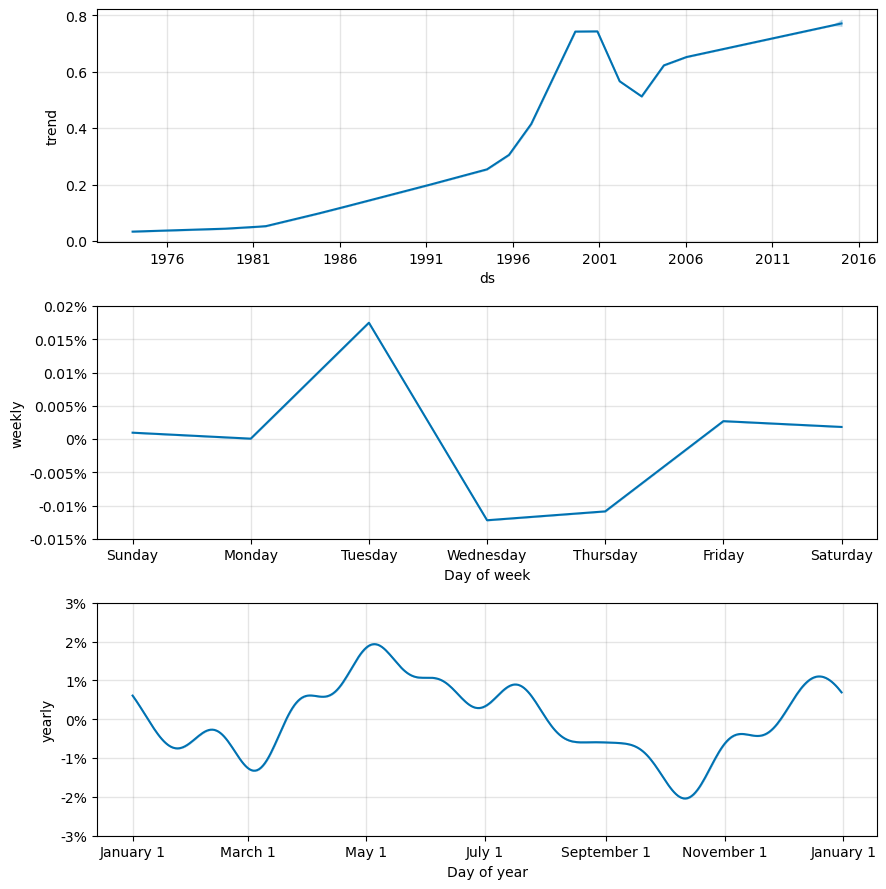

In [15]:
plt = context_prophet.plot_components(context_yhat)

In [6]:
train_df_ticker[0]

,typical_price,ds,series,y
18901,119.943643,2013-10-02,MCK,0.786246
18902,119.009153,2013-10-03,MCK,0.780120
18903,120.164078,2013-10-04,MCK,0.787691
18904,120.040857,2013-10-05,MCK,0.786883
18905,119.917636,2013-10-06,MCK,0.786075
...,...,...,...,...
18987,148.273078,2013-12-27,MCK,0.971949
18988,148.125139,2013-12-28,MCK,0.970979
18989,147.977200,2013-12-29,MCK,0.970009
18990,147.829261,2013-12-30,MCK,0.969040


In [7]:
models = []
for allow_yearly in [False]:
    for seasonality_mode in ["multiplicative"]:
        for allow_weekly in [True]:
            for allow_monthly in [False]:
                for allow_quaterly in [False]:
                    for allow_smp_weekly in [False]:
                        for allow_smp_yearly in [False]:
                            models.append(
                                (
                                    seasonality_mode,
                                    allow_yearly,
                                    allow_weekly,
                                    allow_monthly,
                                    allow_quaterly,
                                    allow_smp_weekly,
                                    allow_smp_yearly,
                                )
                            )

for point in pd.date_range("2015-02-01", "2019-01-01"):
    point = f"{point.year}-{'' if point.month > 9 else '0'}{point.month}-{'' if point.day > 9 else '0'}{point.day}"

    # train_df_smp, test_df_smp, scales_smp = generate_train_test_df_around_point(
    #     window=365 * 35, horizon=365, dfs=smp, for_prophet=True, point=point
    # )
    train_df_ticker, test_df_tickers, scales_tickers = (
        generate_train_test_df_around_point(
            window=91, horizon=365, dfs=gspc_tickers, for_prophet=True, point=point
        )
    )
    for (
        seasonality_mode,
        allow_yearly,
        allow_weekly,
        allow_monthly,
        allow_quaterly,
        allow_smp_weekly,
        allow_smp_yearly,
    ) in models:
        prophet_forecasts = []
        model_name = f"prophet_{point}_{seasonality_mode}"
        if allow_yearly:
            model_name += "_y"

        if allow_weekly:
            model_name += "_w"

        if allow_monthly:
            model_name += "_m"

        if allow_quaterly:
            model_name += "_q"

        if allow_smp_weekly:
            model_name += "_smp_w"

        if allow_smp_yearly:
            model_name += "_smp_yearly"

        csv_path = Path("./") / "out" / "prophet" / "test" / f"{model_name}.csv"
        if csv_path.is_file():
            prophet_metrics = pd.read_csv(csv_path, index_col=0)
            print(f"{model_name} mape: {prophet_metrics['mape'].mean()}")
            continue

        for df, df_test in zip(train_df_ticker, test_df_tickers):
            train_df = df.copy()
            prophet = Prophet(
                seasonality_mode=seasonality_mode,
                yearly_seasonality=allow_yearly,
                weekly_seasonality=allow_weekly,
            )

            if allow_monthly:
                prophet.add_seasonality("monthly", 365.25 / 12, 5)

            if allow_quaterly:
                prophet.add_seasonality("quaterly", 365.25 / 4, 7)

            if allow_smp_weekly:
                prophet.add_regressor(
                    "smp_weekly", standardize=False, mode=seasonality_mode
                )
                train_df["smp_weekly"] = context_yhat[
                    (context_yhat["ds"] >= train_df["ds"].iloc[0])
                    & (context_yhat["ds"] <= train_df["ds"].iloc[-1])
                ]["weekly"].to_numpy()

            if allow_smp_yearly:
                prophet.add_regressor(
                    "smp_yearly", standardize=False, mode=seasonality_mode
                )
                train_df["smp_yearly"] = context_yhat[
                    (context_yhat["ds"] >= train_df["ds"].iloc[0])
                    & (context_yhat["ds"] <= train_df["ds"].iloc[-1])
                ]["yearly"].to_numpy()

            # prophet.add_regressor("smp_yhat", standardize=False, mode="additive")
            # train_df["smp_yhat"] = context_yhat[
            #     (context_yhat["ds"] >= train_df["ds"].iloc[0])
            #     & (context_yhat["ds"] <= train_df["ds"].iloc[-1])
            # ]["yhat"].to_numpy()
            # future["smp_yhat"] = context_yhat[
            #     (context_yhat["ds"] >= future["ds"].iloc[0])
            #     & (context_yhat["ds"] <= future["ds"].iloc[-1])
            # ]["yhat"].to_numpy()
            #

            prophet.fit(train_df)
            future = prophet.make_future_dataframe(periods=365, include_history=True)

            if allow_smp_weekly:
                future["smp_weekly"] = context_yhat[
                    (context_yhat["ds"] >= future["ds"].iloc[0])
                    & (context_yhat["ds"] <= future["ds"].iloc[-1])
                ]["weekly"].to_numpy()

            if allow_smp_yearly:
                future["smp_yearly"] = context_yhat[
                    (context_yhat["ds"] >= future["ds"].iloc[0])
                    & (context_yhat["ds"] <= future["ds"].iloc[-1])
                ]["yearly"].to_numpy()

            prophet_forecasts.append(prophet.predict(future))

        prophet_metrics = get_prophet_metrics(test_df_tickers, prophet_forecasts, 365)
        prophet_metrics.to_csv(csv_path)
        print(f"{model_name} mape: {prophet_metrics['mape'].mean()}")

prophet_2015-02-01_multiplicative_w mape: 0.367331740165391
prophet_2015-02-02_multiplicative_w mape: 0.3570633144018502
prophet_2015-02-03_multiplicative_w mape: 0.3498387854147818
prophet_2015-02-04_multiplicative_w mape: 0.3402727012112321
prophet_2015-02-05_multiplicative_w mape: 0.3335890429448039
prophet_2015-02-06_multiplicative_w mape: 0.3297961123711093
prophet_2015-02-07_multiplicative_w mape: 0.3268930403444995
prophet_2015-02-08_multiplicative_w mape: 0.3312785255076669
prophet_2015-02-09_multiplicative_w mape: 0.3478807882691718
prophet_2015-02-10_multiplicative_w mape: 0.3684929214833808
prophet_2015-02-11_multiplicative_w mape: 0.3879212849855956
prophet_2015-02-12_multiplicative_w mape: 0.4092933013087924
prophet_2015-02-13_multiplicative_w mape: 0.43429434501567343
prophet_2015-02-14_multiplicative_w mape: 0.46624742881248116
prophet_2015-02-15_multiplicative_w mape: 0.4987076694540473
prophet_2015-02-16_multiplicative_w mape: 0.5301458659449532
prophet_2015-02-17_mult

KeyboardInterrupt: 

In [18]:
for point in pd.date_range("2015-01-01", "2020-01-01"):
    print(f"{point.year}-{'' if point.month > 9 else '0'}{point.month}-{'' if point.day > 9 else '0'}{point.day}")

2015-01-01
2015-01-02
2015-01-03
2015-01-04
2015-01-05
2015-01-06
2015-01-07
2015-01-08
2015-01-09
2015-01-10
2015-01-11
2015-01-12
2015-01-13
2015-01-14
2015-01-15
2015-01-16
2015-01-17
2015-01-18
2015-01-19
2015-01-20
2015-01-21
2015-01-22
2015-01-23
2015-01-24
2015-01-25
2015-01-26
2015-01-27
2015-01-28
2015-01-29
2015-01-30
2015-01-31
2015-02-01
2015-02-02
2015-02-03
2015-02-04
2015-02-05
2015-02-06
2015-02-07
2015-02-08
2015-02-09
2015-02-10
2015-02-11
2015-02-12
2015-02-13
2015-02-14
2015-02-15
2015-02-16
2015-02-17
2015-02-18
2015-02-19
2015-02-20
2015-02-21
2015-02-22
2015-02-23
2015-02-24
2015-02-25
2015-02-26
2015-02-27
2015-02-28
2015-03-01
2015-03-02
2015-03-03
2015-03-04
2015-03-05
2015-03-06
2015-03-07
2015-03-08
2015-03-09
2015-03-10
2015-03-11
2015-03-12
2015-03-13
2015-03-14
2015-03-15
2015-03-16
2015-03-17
2015-03-18
2015-03-19
2015-03-20
2015-03-21
2015-03-22
2015-03-23
2015-03-24
2015-03-25
2015-03-26
2015-03-27
2015-03-28
2015-03-29
2015-03-30
2015-03-31
2015-04-01

/home/jovan/miniconda3/envs/new_pymc_env/lib/python3.12/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/jovan/miniconda3/envs/new_pymc_env/lib/python3.12/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/home/jovan/miniconda3/envs/new_pymc_env/lib/python3.12/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing py

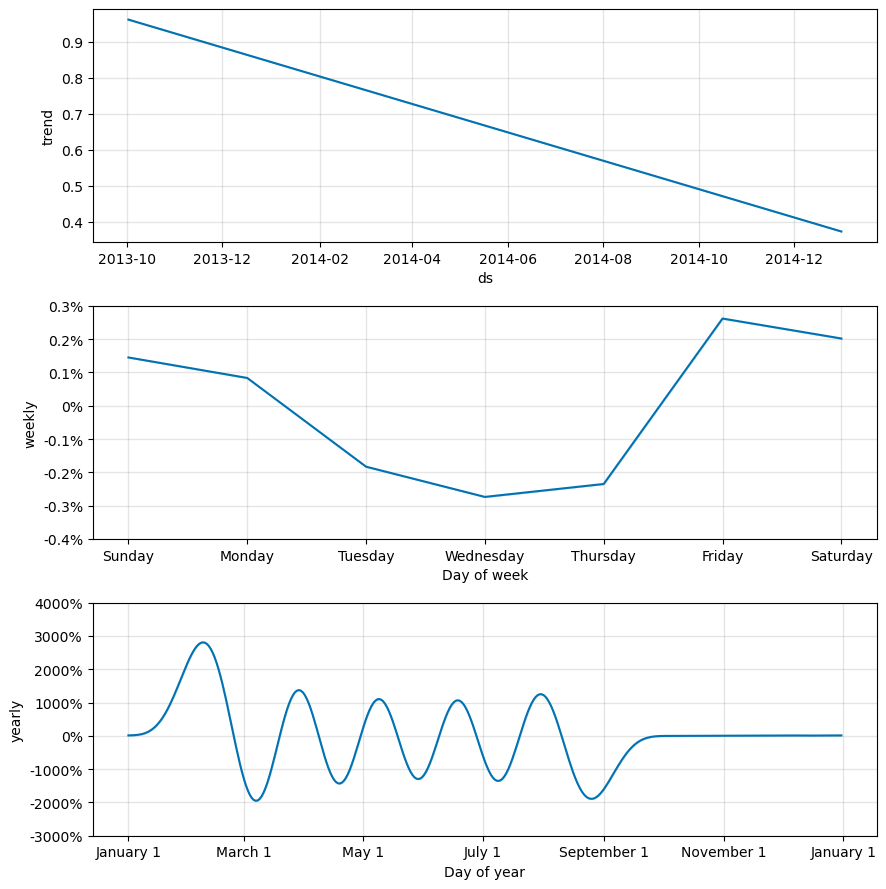

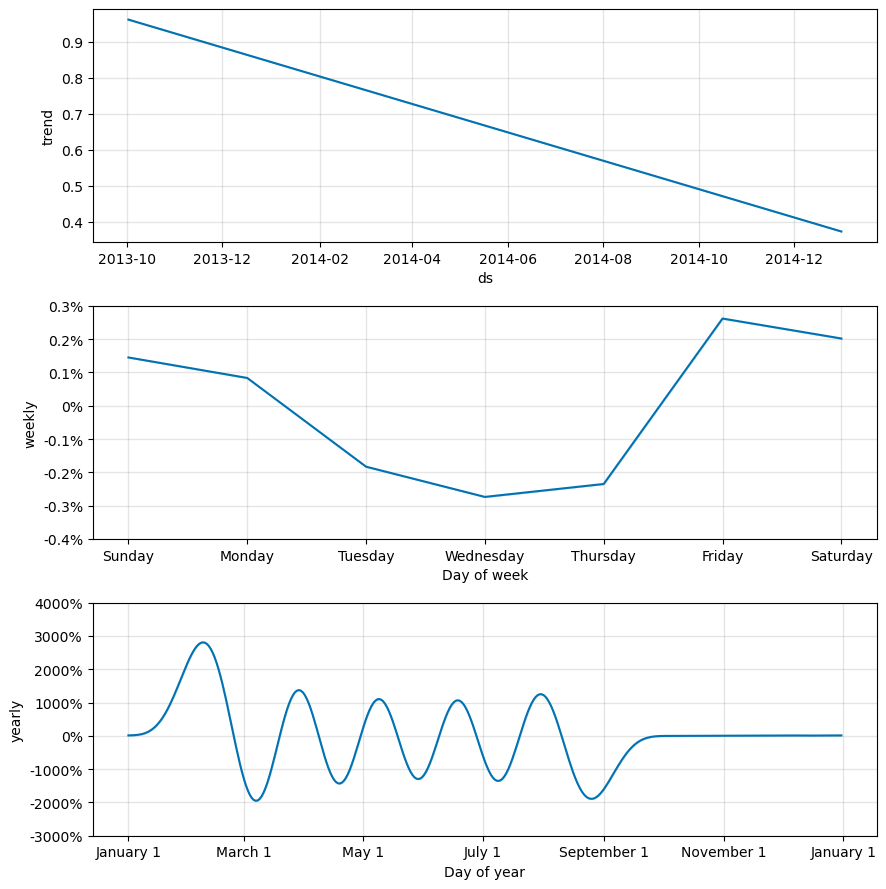

In [31]:
prophet.plot_components(prophet_forecasts[-1])

In [11]:
prophet_metrics

,mse,rmse,mae,mape
MNST,0.033756,0.183728,0.109248,0.074187
PCAR,0.138471,0.372117,0.335363,0.267789
MAR,0.177548,0.421364,0.344359,0.408106
PEP,0.010829,0.104062,0.079326,0.070397
ANSS,0.745597,0.863479,0.735714,0.572273
...,...,...,...,...
DHR,0.002577,0.050760,0.040594,0.038513
RTX,0.196260,0.443012,0.388458,0.346498
FTI,0.558551,0.747363,0.606683,0.389519
EMR,0.086647,0.294358,0.267315,0.237310


# Test model

In [8]:
from typing import Literal

import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as pt

from vangja.time_series import TimeSeriesModel
from vangja.utils import get_group_definition


class FourierSeasonality(TimeSeriesModel):
    def __init__(
        self,
        period,
        series_order,
        beta_mean=0,
        beta_sd=10,
        shrinkage_strength=100,
        pool_cols=None,
        pool_type="complete",
        allow_tune=False,
        tune_method: Literal["same", "simple", "linear", "scaled_linear"] = "same",
    ):
        self.period = period
        self.series_order = series_order
        self.beta_mean = beta_mean
        self.beta_sd = beta_sd
        self.shrinkage_strength = shrinkage_strength

        self.pool_cols = pool_cols
        self.pool_type = pool_type
        self.allow_tune = allow_tune
        self.tune_method = tune_method

    def _fourier_series(self, data):
        # convert to days since epoch
        NANOSECONDS_TO_SECONDS = 1000 * 1000 * 1000
        t = (
            data["ds"].to_numpy(dtype=np.int64)
            // NANOSECONDS_TO_SECONDS
            / (3600 * 24.0)
        )

        x_T = t * np.pi * 2
        fourier_components = np.empty((data["ds"].shape[0], 2 * self.series_order))
        for i in range(self.series_order):
            c = x_T * (i + 1) / self.period
            fourier_components[:, 2 * i] = np.sin(c)
            fourier_components[:, (2 * i) + 1] = np.cos(c)

        return fourier_components

    def definition(self, model, data, initvals, model_idxs):
        model_idxs["fs"] = model_idxs.get("fs", 0)
        self.model_idx = model_idxs["fs"]
        model_idxs["fs"] += 1

        group, n_groups, self.groups_ = get_group_definition(
            data, self.pool_cols, self.pool_type
        )

        x = self._fourier_series(data)
        beta_initval = initvals.get("beta", None)
        if beta_initval is not None:
            if self.pool_type == "partial":
                beta_initval = np.array([beta_initval] * 2 * self.series_order)
            else:
                beta_initval = np.array(
                    [[beta_initval] * 2 * self.series_order] * n_groups
                )

        with model:
            if self.pool_type == "partial":
                mu_beta = pm.Normal(
                    f"fs_{self.model_idx} - beta_mu(p={self.period},n={self.series_order})",
                    mu=self.beta_mean,
                    sigma=self.beta_sd,
                    shape=2 * self.series_order,
                    initval=beta_initval,
                )
                sigma_beta = pm.HalfNormal(
                    f"fs_{self.model_idx} - beta_sigma(p={self.period},n={self.series_order})",
                    sigma=self.beta_sd / self.shrinkage_strength,
                    shape=2 * self.series_order,
                )
                offset_beta = pm.Normal(
                    f"fs_{self.model_idx} - offset_beta(p={self.period},n={self.series_order})",
                    mu=0,
                    sigma=1,
                    shape=(n_groups, 2 * self.series_order),
                )

                beta = pm.Deterministic(
                    f"fs_{self.model_idx} - beta(p={self.period},n={self.series_order})",
                    mu_beta + offset_beta * sigma_beta,
                )
            else:
                beta = pm.Normal(
                    f"fs_{self.model_idx} - beta(p={self.period},n={self.series_order})",
                    mu=self.beta_mean,
                    sigma=self.beta_sd,
                    shape=(n_groups, 2 * self.series_order),
                    initval=beta_initval,
                )

        return pm.math.sum(x * beta[group], axis=1)

    def _tune(self, model, data, initvals, model_idxs, prev):
        if not self.allow_tune:
            return self.definition(model, data, initvals, model_idxs)

        model_idxs["fs"] = model_idxs.get("fs", 0)
        self.model_idx = model_idxs["fs"]
        model_idxs["fs"] += 1

        group, n_groups, self.groups_ = get_group_definition(
            data, self.pool_cols, self.pool_type
        )

        x = self._fourier_series(data)
        beta_initval = initvals.get("beta", None)
        if beta_initval is not None:
            beta_initval = np.array([[beta_initval] * 2 * self.series_order] * n_groups)

        with model:
            beta_key = (
                f"fs_{self.model_idx} - beta(p={self.period},n={self.series_order})"
            )
            beta_mu = (
                prev["map_approx"][beta_key]
                if prev["trace"] is None
                else prev["trace"]["posterior"][beta_key].to_numpy().mean(axis=(1, 0))
            )
            beta_sd = (
                self.beta_sd
                if prev["trace"] is None
                else prev["trace"]["posterior"][beta_key].to_numpy().std(axis=(1, 0))
            )

            if self.tune_method == "simple":
                beta = pm.Normal(
                    beta_key,
                    mu=pt.as_tensor_variable(beta_mu),
                    sigma=pt.as_tensor_variable(beta_sd),
                    shape=(n_groups, 2 * self.series_order),
                    initval=beta_initval,
                )

            if self.tune_method == "linear":
                sigma_beta = pm.Normal(
                    f"fs_{self.model_idx} - beta_sigma(p={self.period},n={self.series_order})",
                    mu=0,
                    sigma=beta_sd,
                    shape=(n_groups, 2 * self.series_order),
                )
                beta = pm.Deterministic(
                    beta_key, pt.as_tensor_variable(beta_mu) + sigma_beta
                )

            if self.tune_method == "scaled_linear":
                sigma_beta = pm.HalfNormal(
                    f"fs_{self.model_idx} - beta_sigma(p={self.period},n={self.series_order})",
                    sigma=beta_sd,
                    shape=2 * self.series_order,
                )
                offset_beta = pm.Normal(
                    f"fs_{self.model_idx} - offset_beta(p={self.period},n={self.series_order})",
                    mu=0,
                    sigma=1,
                    shape=(n_groups, 2 * self.series_order),
                )
                beta = pm.Deterministic(beta_key, beta_mu + offset_beta * sigma_beta)

            if self.tune_method == "same":
                beta = pm.Deterministic(beta_key, pt.as_tensor_variable(beta_mu))

        return pm.math.sum(x * beta[group], axis=1)

    def _det_seasonality_posterior(self, beta, x):
        return np.dot(x, beta.T)

    def _predict_map(self, future, map_approx):
        forecasts = []
        for group_code in self.groups_.keys():
            forecasts.append(
                self._det_seasonality_posterior(
                    map_approx[
                        f"fs_{self.model_idx} - beta(p={self.period},n={self.series_order})"
                    ][group_code],
                    self._fourier_series(future),
                )
            )
            future[f"fs_{self.model_idx}_{group_code}"] = forecasts[-1]

        return np.vstack(forecasts)

    def _predict_mcmc(self, future, trace):
        forecasts = []
        for group_code in self.groups_.keys():
            forecasts.append(
                self._det_seasonality_posterior(
                    trace["posterior"][
                        f"fs_{self.model_idx} - beta(p={self.period},n={self.series_order})"
                    ]
                    .to_numpy()[:, :, group_code]
                    .mean(0),
                    self._fourier_series(future),
                ).T.mean(0)
            )
            future[f"fs_{self.model_idx}_{group_code}"] = forecasts[-1]

        return np.vstack(forecasts)

    def _plot(self, plot_params, future, data, y_max, y_true=None):
        date = future["ds"] if self.period > 7 else future["ds"].dt.day_name()
        plot_params["idx"] += 1
        plt.subplot(100, 1, plot_params["idx"])
        plt.title(f"fs_{self.model_idx} - p={self.period},n={self.series_order}")
        plt.grid()

        for group_code, group_name in self.groups_.items():
            plt.plot(
                date[-int(self.period) :],
                future[f"fs_{self.model_idx}_{group_code}"][-int(self.period) :],
                lw=1,
                label=group_name,
            )

        plt.legend()

    def __str__(self):
        return f"FS(p={self.period},n={self.series_order},at={self.allow_tune},{self.pool_type})"


Output()

0.0874473443346709


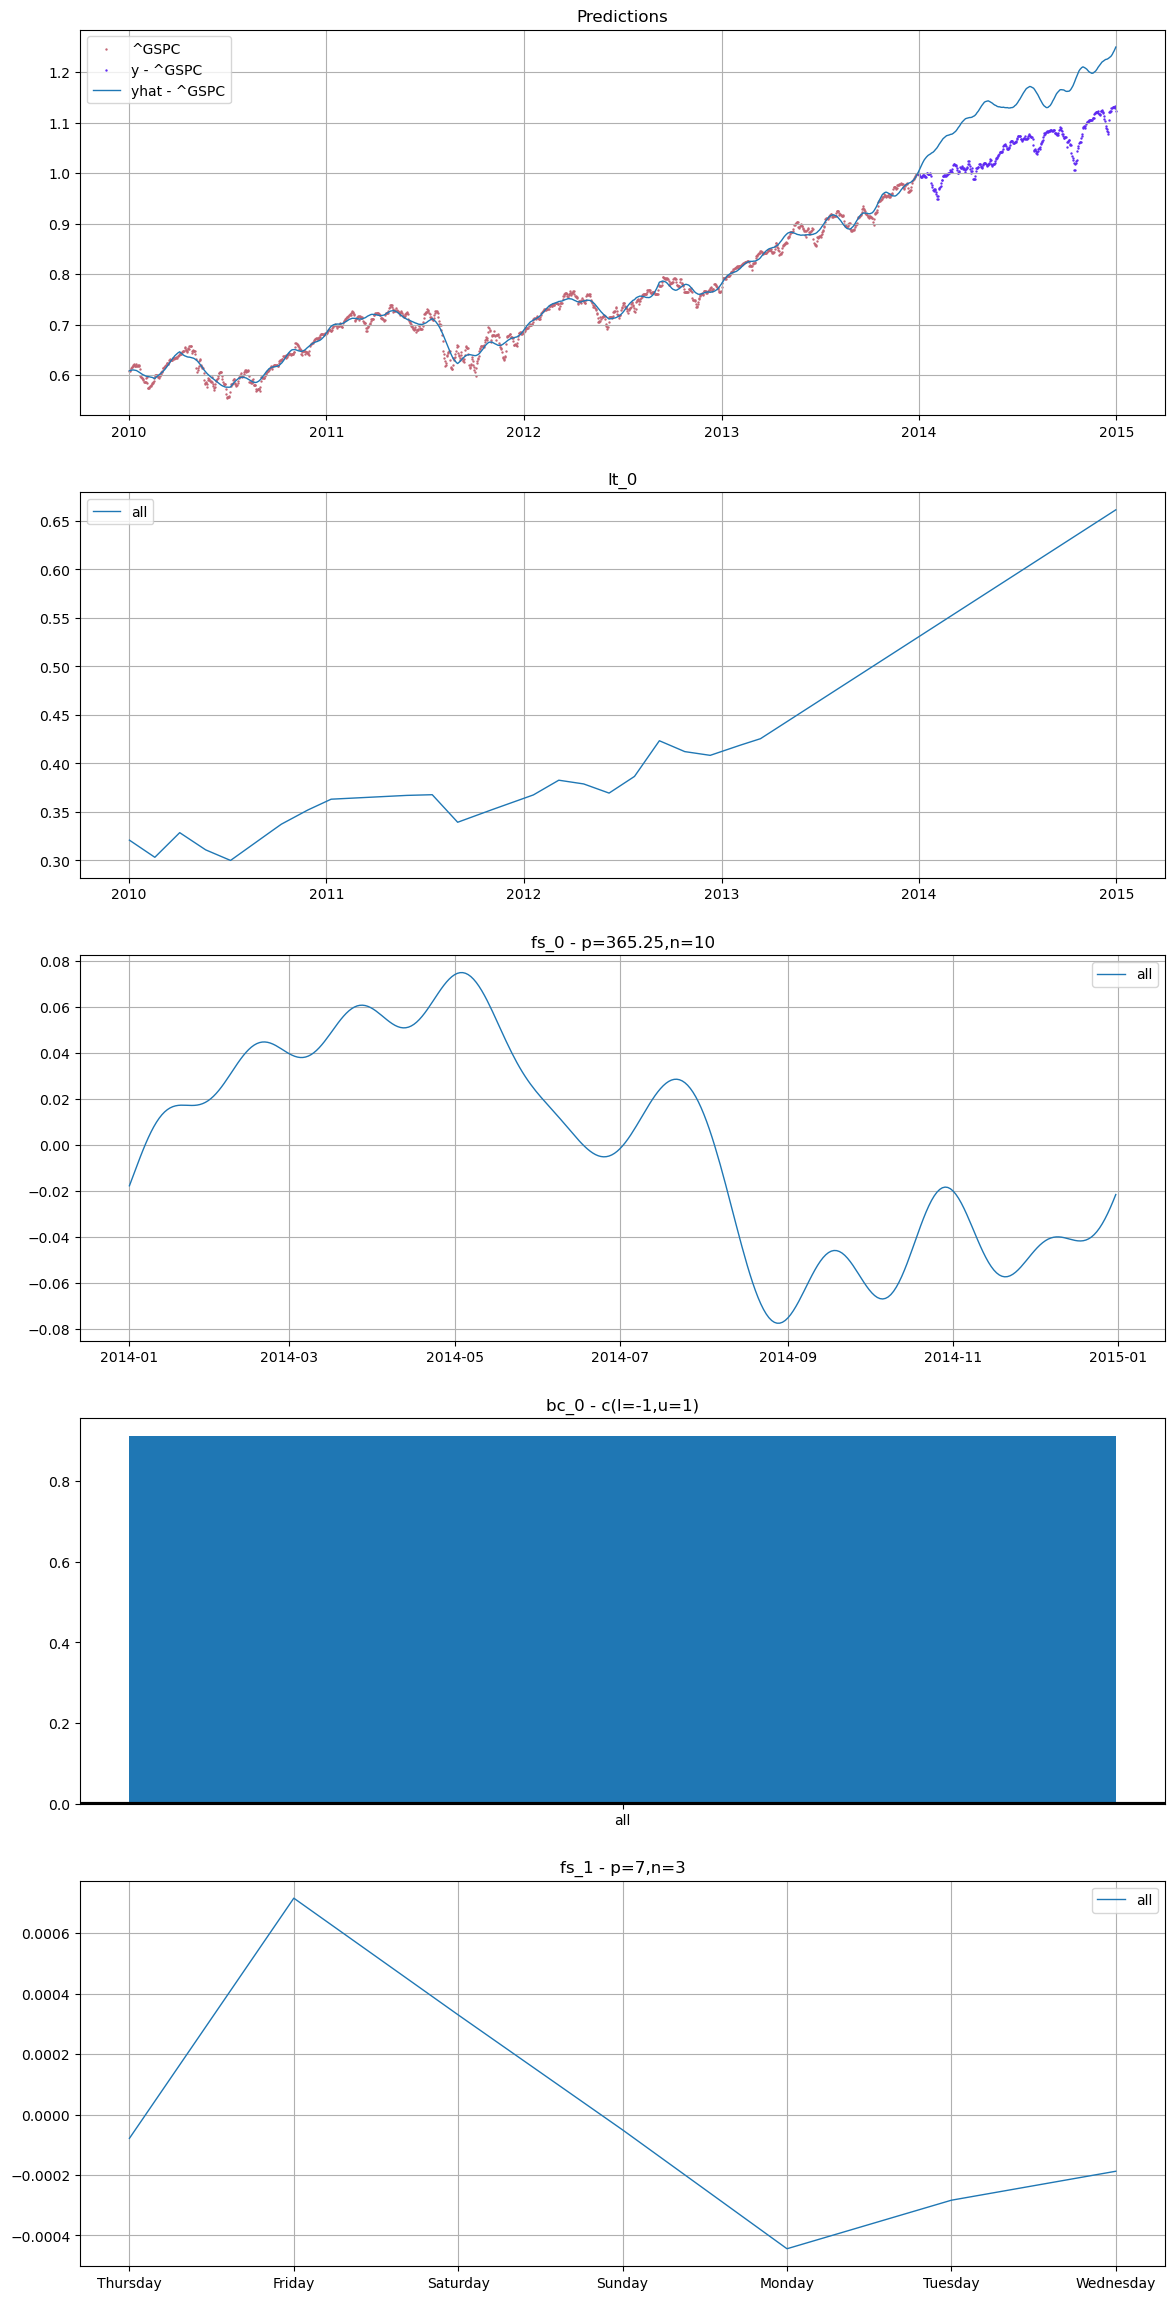

In [15]:
from vangja.components.beta_constant import BetaConstant


model = LinearTrend() * (
    FourierSeasonality(365.25, 10, allow_tune=True, tune_method="simple")
    + BetaConstant(-1, 1)
    * FourierSeasonality(7, 3, allow_tune=True, tune_method="simple")
)
point = "2014-01-01"

train_df_smp, test_df_smp, scales_smp = generate_train_test_df_around_point(
    window=365 * 4, horizon=365, dfs=smp, for_prophet=False, point=point
)
model.fit(train_df_smp, mcmc_samples=0)
yhat = model.predict(365)
print(model.metrics(test_df_smp, yhat, pool_cols="series")["mape"].iloc[0])
model.plot(yhat, test_df_smp, pool_cols="series")

In [20]:
str(model.right.right.right)

'FS(p=7,n=3,at=True,complete)'

In [21]:
model.load_trace(Path("./") / "models" / "trace_40_y_bc_w.nc")
model.fit_params["map_approx"] = None
model.fit_params

{'map_approx': None,
 'trace': Inference data with groups:
 	> posterior
 	> sample_stats
 	> observed_data}

In [22]:
model.left = LinearTrend(pool_cols="series", pool_type="individual")
model.right.left = FourierSeasonality(
    365.25, 10, tune_method="simple", pool_cols="series", pool_type="individual"
)
model.right.right.right = FourierSeasonality(
    7,
    3,
    allow_tune=True,
    tune_method="simple",
    pool_cols="series",
    pool_type="individual",
)
for point in pd.date_range("2015-01-01", "2019-01-01"):
    points = f"{point.year}-{'' if point.month > 9 else '0'}{point.month}-{'' if point.day > 9 else '0'}{point.day}"
    # point = "2015-01-01"
    train_df_tickers, test_df_tickers, scales_tickers = (
        generate_train_test_df_around_point(
            window=91,
            horizon=365,
            dfs=gspc_tickers,
            for_prophet=False,
            point=points,
        )
    )
    model.tune(train_df_tickers, progressbar=True)
    yhat = model.predict(365)
    final_metrics = model.metrics(test_df_tickers, yhat, pool_cols="series")
    final_metrics.to_csv(Path("./") / "out" / "vangja" / "test" / "points.csv")
    print(f"{model}: {final_metrics['mape'].mean()}")

Output()

: 

In [14]:
final_metrics

,mse,rmse,mae,mape
A,0.281052,0.530143,0.462920,0.466692
AAL,0.060901,0.246782,0.220419,0.147460
AAP,0.027532,0.165927,0.142154,0.117400
AAPL,0.097957,0.312981,0.246234,0.194474
ABBV,0.014175,0.119060,0.108196,0.105866
...,...,...,...,...
YUM,0.024342,0.156019,0.126006,0.133125
ZBH,0.021198,0.145595,0.125434,0.113636
ZBRA,0.234560,0.484314,0.370181,0.280726
ZION,0.084489,0.290669,0.244809,0.254641


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


0.42346541007591276


PosixPath('models/trace_40_y_bc_w.nc')

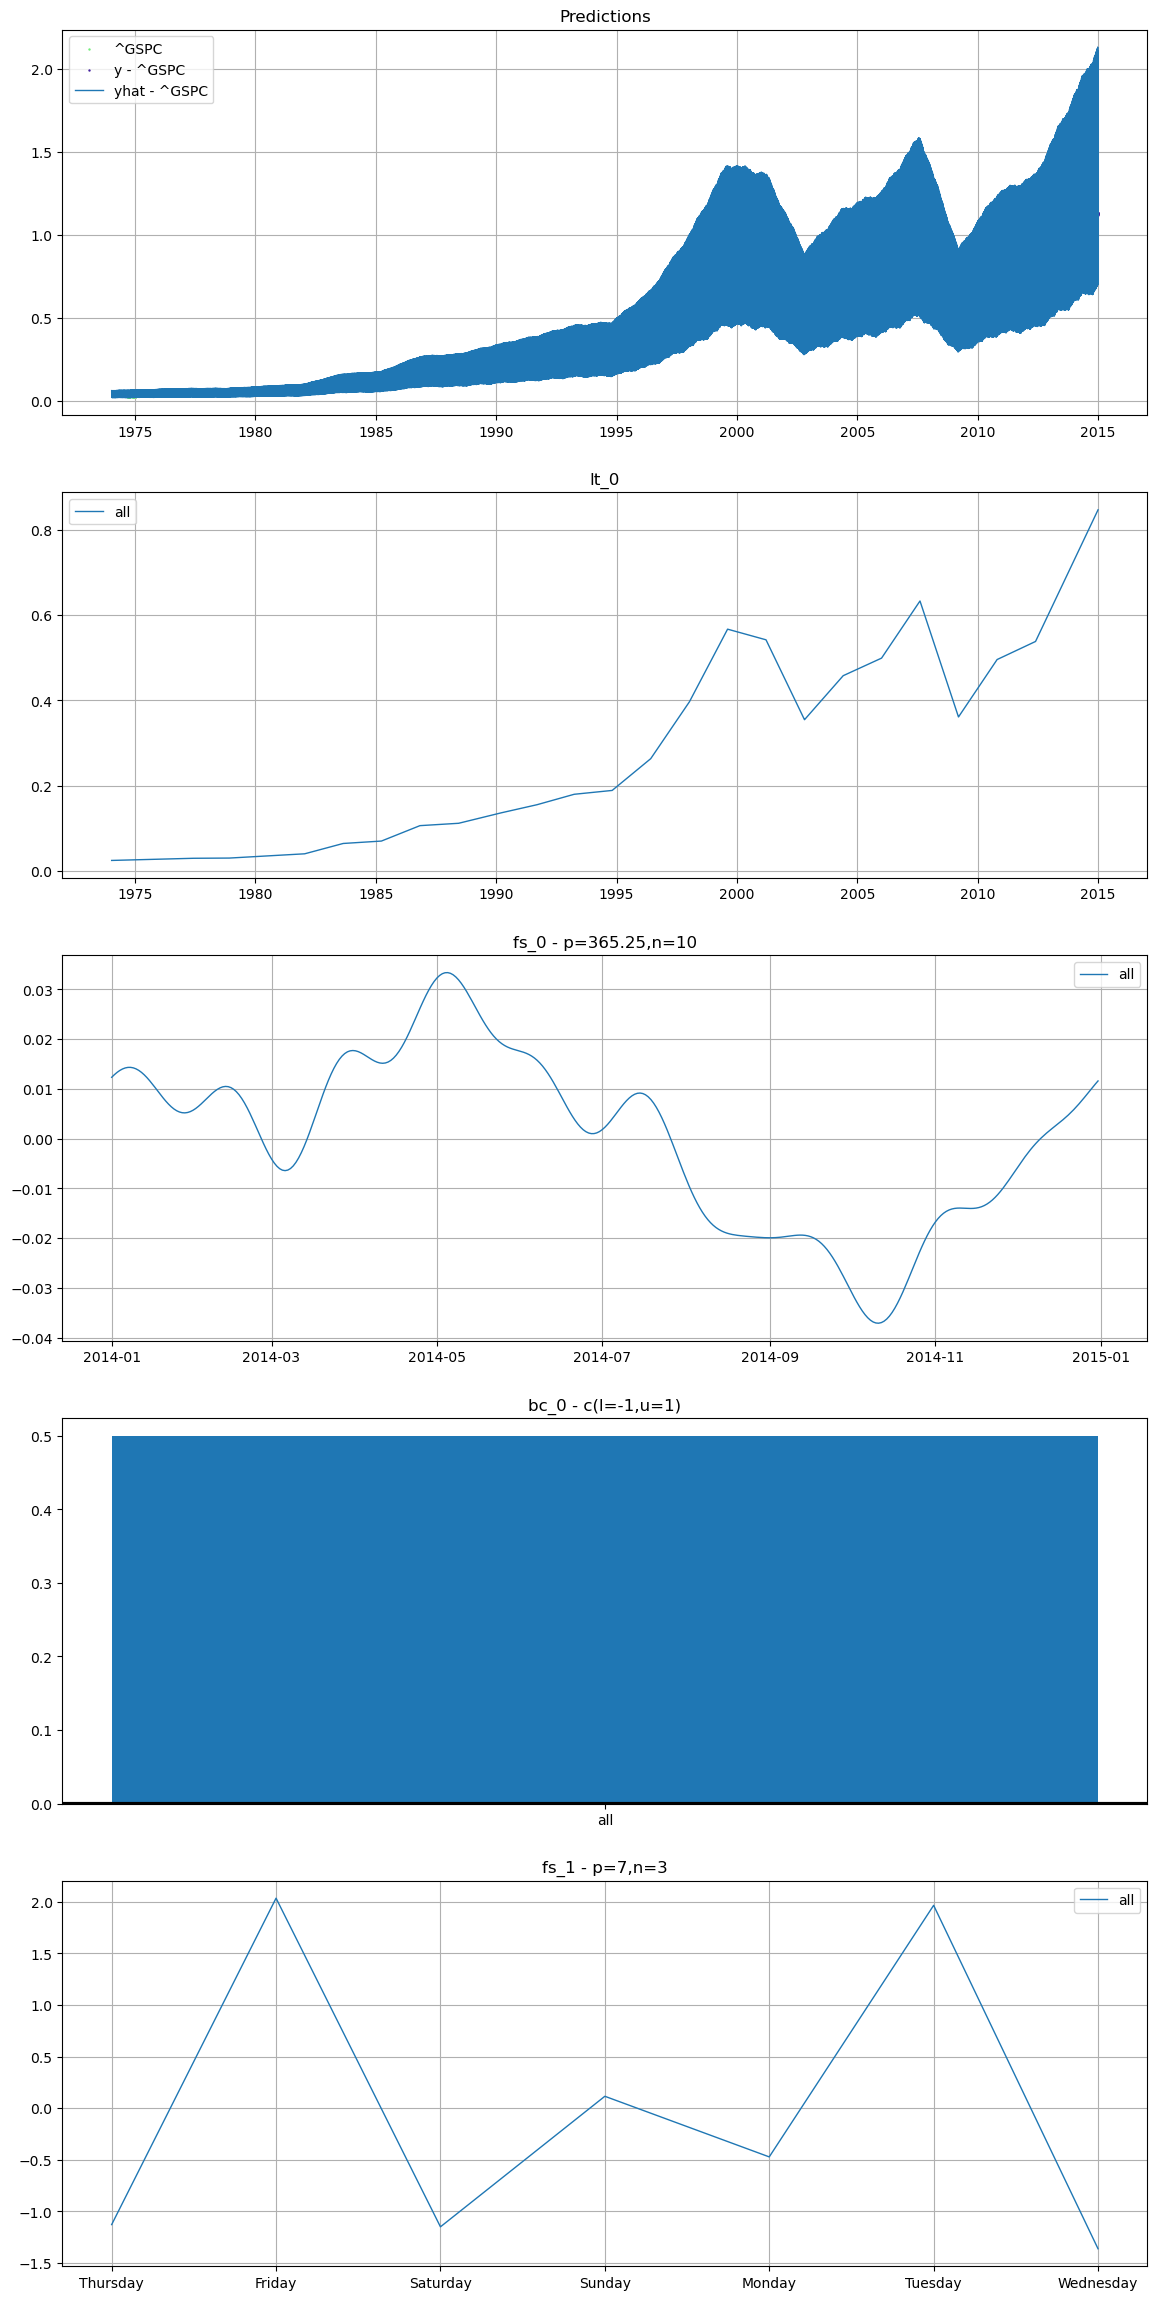

In [23]:
from vangja.components.beta_constant import BetaConstant


model = LinearTrend(changepoint_range=1) * (
    FourierSeasonality(365.25, 10, allow_tune=True, tune_method="simple")
    + BetaConstant(-1, 1)
    * FourierSeasonality(7, 3, allow_tune=True, tune_method="simple")
)
point = "2014-01-01"

train_df_smp, test_df_smp, scales_smp = generate_train_test_df_around_point(
    window=365 * 40, horizon=365, dfs=smp, for_prophet=False, point=point
)

model.fit(train_df_smp, mcmc_samples=1000, nuts_sampler="numpyro")
yhat = model.predict(365)
print(model.metrics(test_df_smp, yhat, pool_cols="series")["mape"].iloc[0])
model.plot(yhat, test_df_smp, pool_cols="series")
model.fit_params["trace"].to_netcdf(Path("./") / "models" / "trace_40_y_bc_w.nc")

In [27]:
# model = LinearTrend(n_changepoints=25, changepoint_range=0.8, allow_tune=True) * (
#     FourierSeasonality(365.25, 10, allow_tune=True)
#     # + FourierSeasonality(91.3125, 7, allow_tune=True)
#     # + FourierSeasonality(30.4375, 5, allow_tune=True)
#     + FourierSeasonality(7, 3, allow_tune=False)
# )
model.load_trace(Path("./") / "models" / "trace_10.nc")
model.fit_params["map_approx"] = None
model.fit_params

{'map_approx': None,
 'trace': Inference data with groups:
 	> posterior
 	> sample_stats
 	> observed_data}

In [19]:
str(model.right.right.right)

'FS(p=7,n=3,at=True,complete)'

In [22]:
model_metrics = []
point = "2014-01-01"
model.left.changepoint_range = 0.8
# model.right.left.right.tune_method = "linear"

for gspc_ticker in tqdm(gspc_tickers):
    # if gspc_ticker["series"].iloc[0] not in good_stocks:
    #     continue
    
    check = generate_train_test_df_around_point(
        window=91,
        horizon=365,
        dfs=[gspc_ticker],
        for_prophet=False,
        point=point,
    )

    if check is None:
        continue
    
    model.right.left.beta_sd = 0.001
    model.right.right.right.beta_sd = 0.001

    train_df_tickers, test_df_tickers, scales_tickers = check
    model.tune(train_df_tickers, progressbar=False)
    yhat = model.predict(365)
    model_metrics.append(model.metrics(test_df_tickers, yhat, pool_cols="series"))

final_metrics = pd.concat(model_metrics)
# final_metrics.to_csv("my_result_linear_2014_80.csv")
print(f"{model}: {final_metrics['mape'].mean()}")

100%|██████████| 503/503 [24:31<00:00,  2.92s/it]

LT(n=25,r=0.8,at=False,complete) * (FS(p=365.25,n=10,at=True,complete) + BC(alpha=0.5,beta=0.5,l=-1,u=1,at=False,complete) * FS(p=7,n=3,at=True,complete)): 0.2691423301126675
